In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
# OLD WRONG bug version
# file = os.path.join(cluster_dir,"20221122_full_supercluster_recordings_250_hemi_doubled.npy")
# supercluster_signals = np.load(file)
# supercluster_signals.shape

### CORRECT VERSION ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
### Load Neural Data ###
all_neural = np.load('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_z_vox_t_correct.npy')
all_neural.shape

(49, 2000, 30456)

In [9]:
### load sv_to_sc to relate supervoxels and superclusters ###
# this tells us what supercluster each supervoxel belongs to
# file = os.path.join(cluster_dir,"20221128_sv_to_sc.npy")
# sv_to_sc = np.load(file)
# sv_to_sc.shape

(49, 2000)

In [5]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [6]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [7]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [8]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 32.34 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.31 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 35.84 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.38 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 18.41 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.28 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 36.35 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.43 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.50 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.41 sec
*** fly: fl

In [9]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [9]:
##############################
### TEMPORAL SHIFT VERSION ###
##############################

z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super_z = {}
for z in range(49):
    behavior_super_z[z] = {}
    for behavior in behaviors:
        behavior_super_z[z][behavior] = []
        for fly in fly_names:
            behavior_super_z[z][behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
        behavior_super_z[z][behavior] = np.asarray(behavior_super_z[z][behavior])
        behavior_super_z[z][behavior + '_std'] = behavior_super_z[z][behavior]/np.std(behavior_super_z[z][behavior])


In [10]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    #bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
    #bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))
    
#     bins_x = [x / 10.0 for x in range(-20, 64, 4)]
#     bins_y = [x / 10.0 for x in range(-40, 44, 4)]
#     num_bins_x = 22
#     num_bins_y = 22
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], bins_x, bins_y

def plot_2D_hist(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = temporal[:,0]
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
       
    if behavior_type in ['velocity', 'velocity_pooled']:
        start_x=-2; end_x=8; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(1.5,linestyle='--',color='k',linewidth=1)
    if behavior_type in ['acceleration', 'acceleration_pooled']:
        start_x=-5; end_x=5; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(4.5,linestyle='--',color='k',linewidth=1)
    
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                             num_bins_x=10, num_bins_y=10,
                                             start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y)
    
    ax.imshow(fictrac_2d,cmap='PuOr',vmin=-1,vmax=1)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
def plot_2D_scatter(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    
    ax.scatter(x=X_var,
               y=Y_var,
               c=signal,
               marker='x',cmap='PuOr',vmin=-1,vmax=1,s=.5,linewidth=.1) #s,.2,lw=0
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.axhline(0,linestyle='--',color='k',linewidth=1)
    ax.axvline(0,linestyle='--',color='k',linewidth=1)

In [11]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/20221202_master_X_noYclip.npy"
X_beh = np.load(file)
X_beh.shape

(49, 9, 2000, 3384)

In [12]:
# the main thing to deal with now is the z-depth
# for a given supercluster, i need to know the original median z-depth for each fly

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

100%|██████████| 9/9 [00:00<00:00, 243.56it/s]


In [13]:
superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

(256, 128, 49)

In [14]:
original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:31<00:00,  3.48s/it]


In [17]:
60*20

1200

In [22]:
cluster = 116
Xs_new = []
for fly in range(9):
    Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
Xs_new = np.asarray(Xs_new)
beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))


for j,shift in tqdm.tqdm(enumerate(np.arange(-50,50,1))):
    Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
    Y_var /= np.std(Y_var)

    X_var = beh_cluster[250+shift,:]
    X_var /= np.std(X_var)

    start_x=-2; end_x=6; start_y=-4; end_y=4

    signal = supercluster_signals[cluster,:]
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    vmax = .1#np.percentile(np.abs(fictrac_2d),98)
    
    plt.figure(figsize=(20,10))
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20221202_2dhist_movies/116'
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, '{0:05d}.png'.format(j))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.cla()
    plt.clf()

100it [04:19,  2.60s/it]


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [20]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20221202_2dhist_movies/116'
os.mkdir(save_path)

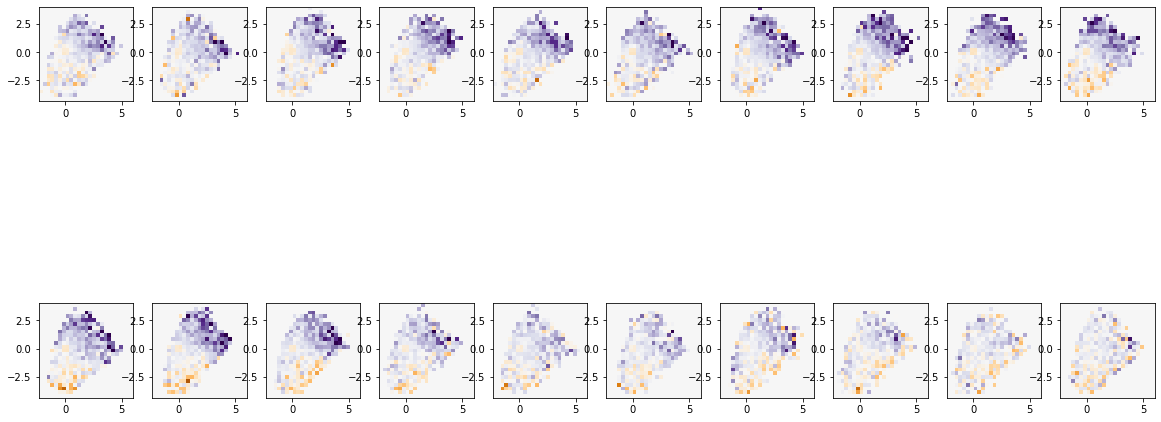

In [15]:
cluster = 116
Xs_new = []
for fly in range(9):
    Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
Xs_new = np.asarray(Xs_new)
beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

plt.figure(figsize=(20,10))

for j,shift in enumerate(np.arange(-60,60,6)):
    Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
    Y_var /= np.std(Y_var)

    X_var = beh_cluster[250+shift,:]
    X_var /= np.std(X_var)

    start_x=-2; end_x=6; start_y=-4; end_y=4

    signal = supercluster_signals[cluster,:]
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    vmax = .1#np.percentile(np.abs(fictrac_2d),98)
    
    plt.subplot(2,10,j+1)
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])

In [16]:
def vidwrite(fn, images, framerate=60, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width,channels = images.shape
    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in images:
        process.stdin.write(
            frame
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [13]:
# define top and bottom colormaps 
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

In [17]:
all_neural.shape, sv_to_sc.shape

((49, 2000, 30456), (49, 2000))

In [69]:
supercluster = 77
ind = np.where(sv_to_sc==supercluster)
ind

(array([14, 14, 15, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
        20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
        29, 31, 37, 38, 39]),
 array([ 211,  903,  154, 1674,  111,  264,  645, 1336, 1502, 1592, 1818,
        1900,   43,  569,  847, 1033, 1391, 1598, 1753, 1972,  184,  256,
         477, 1050, 1087, 1379, 1672, 1688, 1699,  417,  457, 1546, 1701,
        1896,  391,  589, 1884,   54, 1438]))

In [78]:
corrs = []
for num,cluster in enumerate(range(len(ind[0]))):#range(50):
    #signal = supercluster_signals[cluster,:]
    signal = all_neural[ind[0][cluster], ind[1][cluster],:]
    beh = 'Z_neg_std'
    corrs.append(scipy.stats.pearsonr(signal, behavior_super[beh])[0])
print(np.mean(corrs))

0.04888749828977604


In [ ]:
# cluster 77 green is 0.03, red is 0.05. ie this prefers right turning

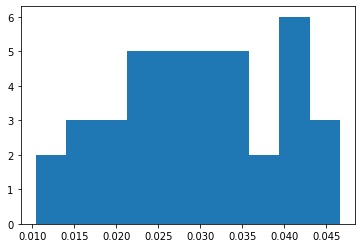

In [76]:
plt.hist(corrs);

In [56]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

behavior_super = {}
behavior_super['Y_pos_std'] = beh_fwd
behavior_super['Z_pos_std'] = np.clip(beh_turn,0,None)
behavior_super['Z_neg_std'] = np.clip(beh_turn,None,0)*-1

(30456,)
(30456,)


In [65]:
all_neural.shape

(49, 2000, 30456)

In [80]:
signals = []
for num,cluster in enumerate(range(len(ind[0]))):#range(50):
    #signal = supercluster_signals[cluster,:]
    signals.append(all_neural[ind[0][cluster], ind[1][cluster],:])
signals = np.mean(np.asarray(signals),axis=0)
beh = 'Z_neg_std'
scipy.stats.pearsonr(signals, behavior_super[beh])[0]

0.1922707722685318

In [59]:
signals.shape

(30456,)

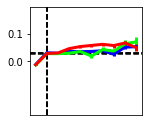

In [81]:
signal = signals
plt.figure(figsize=(2,2))
plot_supercluster_vs_beh()

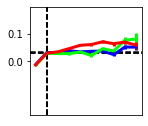

In [82]:
signal=supercluster_signals[77,:]
plt.figure(figsize=(2,2))
plot_supercluster_vs_beh()

In [11]:
signal=all_neural[ind[0][25],ind[1][25],:]
plt.figure(figsize=(2,2))
plot_supercluster_vs_beh()

NameError: name 'ind' is not defined

In [97]:
### Load GLM output
main_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210208_inst_uniq_glm'

### this is what I initially warped into FDA but probably want the other one
#main_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210309_inst_uniq_glm_state_sub'

all_scores = []
for z in range(9,49-9):
    file = [os.path.join(main_dir, i) for i in os.listdir(main_dir) if f'Z{z}.' in i][0]
    with open(file, 'rb') as handle:
        scores = pickle.load(handle)
    all_scores.append(scores)

In [104]:
all_scores[21-9]['scores_zpos'][1379], all_scores[21-9]['scores_zneg'][1379]
# this says zneg is higher, which is VR

(0.03655496692299366, 0.10909063826421762)

In [18]:
def plot_supercluster_vs_beh():#supercluster):
    #neu = supercluster #shortcut
    for beh,color in zip(['Y_pos_std', 'Z_pos_std', 'Z_neg_std'],[(0,0,1),(0,1,0),(1,0,0)]):
        #cmap = matplotlib.cm.get_cmap(color)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,5,num_bins+1)
        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
            avgs.append(np.mean(signal[a]))
            stds.append(np.std(signal[a]))
            cnts.append(len(a[0]))

        #plt.scatter(behavior_super[beh],supercluster_signals[neu],marker='.',color='grey',s=1)

        ### Plot line along bins, with error bar ###
        sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
        plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color=color,lw=3)

        plt.axhline(avgs[1],color='k',linestyle='--')
        plt.axvline(mids[1],color='k',linestyle='--')
        plt.xlim(0,5)
        plt.ylim(-.2,.2)
        plt.xticks([])
        plt.yticks([0,.1])
        #ax.set_yticklabels([0,.1])
        #ax.set_yticks([0,.1])

In [ ]:
### OK, SO....
# again my original supercluster_signals look the worst
# it looks more correct if calulate the signal directly from averaging the SV in the SC
# (instead of turning the SVs into a 3D image and taking from there)
# I'm not sure exactly why this makes a difference

In [15]:
all_neural.shape

(49, 2000, 30456)

In [16]:
cluster = 77
ind = np.where(sv_to_sc==cluster)
ind_pairs = [(ind[0][i],ind[1][i]) for i in range(len(ind[0]))]

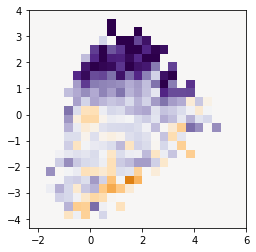

In [46]:
#signal=signals
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
start_x=-2; end_x=6; start_y=-4; end_y=4
idx=12
#signal = all_neural[ind_pairs[idx][0],ind_pairs[idx][1],:]
signal=supercluster_signals[77,:]
fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)
fictrac_2d[-1,:] = 0
vmax = np.percentile(np.abs(fictrac_2d),98)
plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])

In [91]:
all_neural.shape

(49, 2000, 30456)

In [15]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels_2000 = np.load(labels_file)
cluster_model_labels_2000.shape
cluster_model_labels_2000_3d = np.reshape(cluster_model_labels_2000,(49,256,128))

In [41]:
cluster_model_labels_2000_3d.shape

(49, 256, 128)

In [56]:
z=10
empty = np.zeros((256,128))
for cluster in range(2000):
    ind = np.where(cluster_model_labels_2000_3d[z,:,:]==cluster)
    empty[ind[0],ind[1]] = all_neural[z,cluster,0]

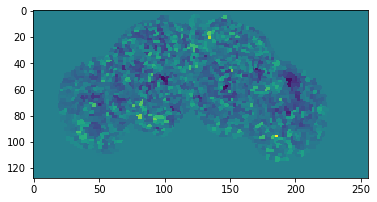

In [57]:
plt.imshow(empty.T)

In [94]:
signal = all_neural[ind[0][25],ind[1][25],:].shape

(30456,)

(21, 1379)

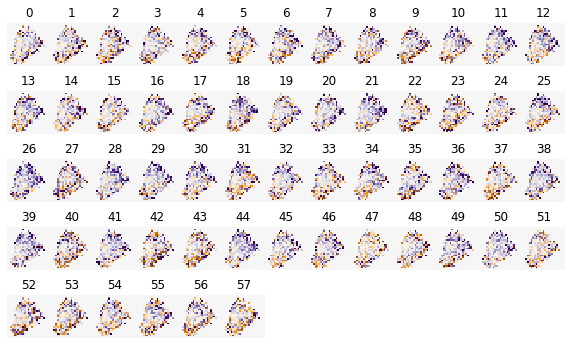

In [47]:
cluster = 86
ind = np.where(sv_to_sc==cluster)
ind_pairs = [(ind[0][i],ind[1][i]) for i in range(len(ind[0]))]

#X_var = behavior_super['Y_std']
#Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

for num,cluster in enumerate(range(len(ind_pairs))):#range(50):
    #signal = supercluster_signals[cluster,:]
    signal = all_neural[ind_pairs[cluster][0],ind_pairs[cluster][1],:]
    plt.subplot(8,13,cluster+1)
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    #vmax = np.percentile(fictrac_2d,99)
    vmax = np.percentile(np.abs(fictrac_2d),98)
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    plt.title(num)
    #plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

#     ax = plt.gca()
#     if num == 0:
        
#         ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
#         ax.set_yticklabels([-300, 0, 300])
#         ax.set_yticks([-300*ratio, 0, 300*ratio])

#         ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
#         ax.set_xticklabels([0, 10])
#         ax.set_xticks([0, 10*ratio])

#         plt.ylabel('Vr deg/sec')
#         plt.xlabel('Vf mm/sec')
#     else:
#         ax.xaxis.set_visible(False)
#         ax.yaxis.set_visible(False)
    
    #ax.axhline(0,linestyle='--',color='k',linewidth=1)
    #ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [48]:
import tqdm

In [49]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
start_x=-2; end_x=6; start_y=-4; end_y=4

supercluster_2d_hists = []
for cluster in tqdm.tqdm(range(501)):
    signal = supercluster_signals[cluster,:]
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    supercluster_2d_hists.append(fictrac_2d)

100%|██████████| 501/501 [00:26<00:00, 18.84it/s]


In [50]:
supercluster_2d_hists = np.asarray(supercluster_2d_hists)
supercluster_2d_hists.shape

(501, 25, 25)

In [1]:
plt.imshow(supercluster_2d_hists[77,:,:])

NameError: name 'plt' is not defined

In [52]:
save_file = os.path.join(cluster_dir,"20221122_full_supercluster_2d_beh_hists")
np.save(save_file,supercluster_2d_hists)

In [26]:
# ALSO SAVE BEHAVIOR
save_file = os.path.join(cluster_dir,"20221122_behavior_fwd")
np.save(save_file, X_var)

save_file = os.path.join(cluster_dir,"20221122_behavior_turn")
np.save(save_file, Y_var)

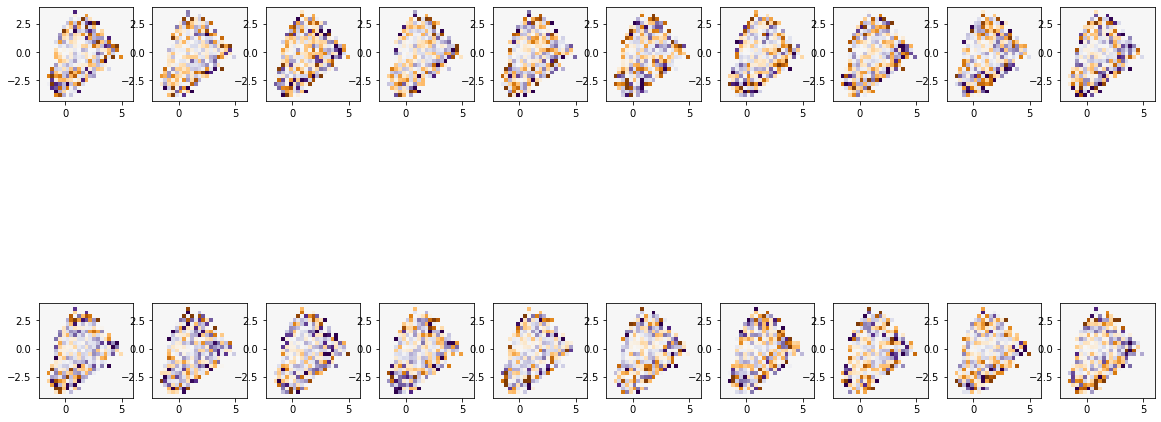

In [57]:
plt.figure(figsize=(20,10))
for j,roll in enumerate(np.arange(-10,10,1)):
    X_var = behavior_super_z[20]['Y_std']
    Y_var = behavior_super_z[20]['Z_std']

    start_x=-2; end_x=6; start_y=-4; end_y=4

    cluster = 138
    signal = supercluster_signals[cluster,:]
    fictrac_2d, bins_x, bins_y = bin_2D_plot(np.roll(X_var,roll), np.roll(Y_var,roll), signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0

    vmax = np.percentile(np.abs(fictrac_2d),98)
    #vmax=.04
    plt.subplot(2,10,j+1)
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])

In [47]:
vmax

0.028415196820920047

# fixing bug!

In [21]:
svs = np.array([[  26,   28,   28,   28,   26,   28,   26,   28,   26,   28,   26,
          28,   26,   26,   26,   27,   26,   27,   26,   27,   28,   26,
          27,   28,   26,   27,   28,   26,   28,   26,   28,   26,   28,
          26,   26,   26,   29,   26,   27,   29,   26,   27,   29,   26,
          27,   28,   29,   26,   27,   28,   26,   27,   28,   26,   27,
          28,   26,   28,   26,   28,   29,   27,   29,   26,   27,   29,
          26,   27,   26,   27,   30,   26,   27,   29,   30,   26,   27,
          29,   30,   26,   27,   28,   29,   26,   27,   28,   29,   27,
          28,   29,   27,   28,   27,   28,   27,   28,   27,   29,   33,
          27,   29,   33,   26,   27,   29,   30,   33,   26,   27,   28,
          29,   30,   33,   26,   27,   28,   29,   30,   33,   26,   27,
          28,   29,   30,   26,   27,   28,   29,   30,   26,   27,   28,
          29,   26,   27,   28,   29,   27,   28,   29,   27,   28,   27,
          28,   27,   28,   27,   29,   33,   29,   33,   27,   29,   30,
          33,   27,   28,   29,   30,   33,   27,   28,   29,   30,   33,
          27,   28,   29,   30,   27,   28,   29,   30,   27,   28,   29,
          27,   28,   29,   27,   28,   29,   27,   28,   29,   27,   28,
          29,   27,   29,   29,   34,   33,   34,   29,   33,   34,   29,
          30,   33,   27,   28,   29,   30,   33,   27,   28,   29,   30,
          33,   27,   28,   29,   30,   27,   28,   29,   27,   28,   29,
          27,   28,   29,   27,   28,   29,   27,   28,   29,   29,   29,
          34,   34,   29,   33,   34,   29,   30,   33,   34,   28,   29,
          30,   33,   34,   28,   29,   33,   28,   29,   27,   28,   29,
          27,   28,   29,   27,   28,   29,   27,   28,   29,   27,   28,
          29,   29,   29,   34,   34,   34,   29,   34,   28,   29,   30,
          34,   28,   29,   28,   29,   27,   29,   27,   29,   27,   28,
          29,   27,   28,   29,   27,   28,   34,   34,   29,   34,   29,
          34,   29,   29,   27,   29,   27,   29,   27,   28,   29,   27,
          28,   29,   27,   28,   27,   29,   34,   34,   27,   27,   28,
          27],
       [ 438, 1068, 1068,  179, 1534,  179,  438, 1210,  438, 1210,  438,
        1068,  482,  482, 1534,  788, 1534, 1829, 1534, 1829,  179, 1534,
         276,  179,  438,  276, 1210,  438, 1210,  438, 1210,  539, 1210,
         482,  482,  482,  161, 1534,  788,  161, 1534, 1829,  161, 1005,
        1829, 1837,  161, 1005,  276, 1837,  889,  276, 1210,  889,  276,
        1210,  889, 1210,  889, 1210,  643, 1306,  643,    2, 1941,  643,
         371,  308,  371,  308, 1303,  371,  308,  161, 1303,  371, 1829,
         161, 1303, 1005, 1829, 1837,  161, 1005, 1829, 1837,  804, 1829,
        1837,  804,  396, 1837,  396, 1949,  396, 1949,  178, 1587,  940,
        1941, 1587,  940,    2, 1941,   55, 1325,  940,  371,  308,  882,
          55, 1325, 1574,  371,  308,  882,   55, 1303, 1574,  371,  308,
         882,  354, 1303, 1005, 1829, 1837,  354, 1303, 1005, 1829, 1837,
         804, 1005, 1829, 1837,  804, 1829, 1837,  804,  396, 1837,  396,
        1949,  396, 1949, 1593, 1587,  940, 1587,  940, 1941,  597,  947,
         940,  308,  476,  597,  279, 1574,  308,  476,  354,  279, 1574,
        1766,  476,  354, 1505, 1766, 1837,  354, 1505, 1766, 1837,  804,
        1766, 1567,  804, 1766, 1567,  817, 1766, 1567,  817,  396, 1949,
         817,  396,  817,  402,  703,  940, 1993,  597,   29, 1993,  597,
         947,   29, 1941,  476,  597,  279, 1574, 1766,  476,  354,  279,
        1574, 1766, 1651,  354, 1505, 1766, 1651,  354, 1766, 1567,  804,
        1766, 1567,  804, 1766, 1567,  817,  744, 1567,  817,  817,  817,
        1089, 1993, 1587,   29, 1993,  597,  947,   29, 1993,  339,  597,
         279, 1574, 1785,  339,  270, 1574, 1651,  270, 1766, 1651,  270,
        1766, 1567, 1364, 1766, 1567, 1364,  744, 1567,  817,  744, 1567,
         817,  817,  468, 1089, 1993, 1993,  597, 1993,  339,  597, 1415,
         561, 1651,  270, 1651,  270,  158,  270,  158, 1364,  158, 1567,
        1364,  744, 1567, 1364,  744, 1567, 1993, 1993,  924, 1515, 1890,
         561, 1890,  270,  158,  270,  158,  647,  158, 1246,  647,  744,
        1246, 1364,  744, 1567, 1642,  924, 1515,  561,  819,  819, 1442,
        1642]])

In [23]:
# lets pick one supervoxel to play with. lets do a weird voxel in supercluster 77
z=30
sv=1608

In [13]:
all_neural.shape #z is P to A

(49, 2000, 30456)

In [16]:
cluster_model_labels_2000.shape #z is P to A

(49, 32768)

In [26]:
all_neural[svs[0],svs[1],:].shape

(320, 30456)

In [37]:
file = os.path.join(cluster_dir, "20221202_KEY_sv_in_sc.npy")
KEY_SVSC = np.load(file,allow_pickle=True)

In [39]:
KEY_SVSC[SC][0]

array([ 0,  1,  2, ..., 46, 47, 48])

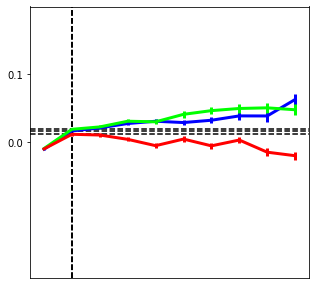

In [44]:
SC = 116
signal=np.mean(all_neural[KEY_SVSC[SC][0],KEY_SVSC[SC][1],:],axis=0)
plt.figure(figsize=(5,5))
plot_supercluster_vs_beh()

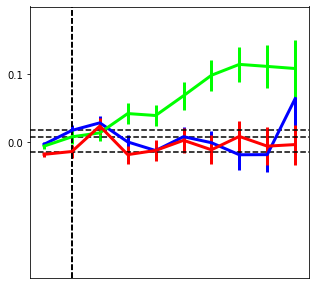

In [24]:
signal=all_neural[z,sv,:]
plt.figure(figsize=(5,5))
plot_supercluster_vs_beh()

In [74]:
sv_to_sc.shape

(49, 2000)

In [82]:
cluster = 77
ind = np.where(sv_to_sc==cluster)
ind_pairs = [(ind[0][i],ind[1][i]) for i in range(len(ind[0]))]
ind_pairs

[(14, 211),
 (14, 903),
 (15, 154),
 (18, 1674),
 (19, 111),
 (19, 264),
 (19, 645),
 (19, 1336),
 (19, 1502),
 (19, 1592),
 (19, 1818),
 (19, 1900),
 (20, 43),
 (20, 569),
 (20, 847),
 (20, 1033),
 (20, 1391),
 (20, 1598),
 (20, 1753),
 (20, 1972),
 (21, 184),
 (21, 256),
 (21, 477),
 (21, 1050),
 (21, 1087),
 (21, 1379),
 (21, 1672),
 (21, 1688),
 (21, 1699),
 (22, 417),
 (22, 457),
 (22, 1546),
 (22, 1701),
 (22, 1896),
 (29, 391),
 (31, 589),
 (37, 1884),
 (38, 54),
 (39, 1438)]

In [83]:
np.where(sv_to_sc==77)

(array([14, 14, 15, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
        20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
        29, 31, 37, 38, 39]),
 array([ 211,  903,  154, 1674,  111,  264,  645, 1336, 1502, 1592, 1818,
        1900,   43,  569,  847, 1033, 1391, 1598, 1753, 1972,  184,  256,
         477, 1050, 1087, 1379, 1672, 1688, 1699,  417,  457, 1546, 1701,
        1896,  391,  589, 1884,   54, 1438]))